In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from plotnine import ggplot, aes, geom_line, facet_wrap, theme_bw, theme, scale_x_continuous, element_blank, labs
from keras import regularizers

import re
import os
import sys

In [2]:
# clones the github repository for use in google colab notebooks
from google.colab import userdata
accessToken = userdata.get('AccessToken')

# accesses the github dataset by cloning the repository and downloading its contents
token = accessToken
repo_url = f"https://{token}@github.com/SleepDeprived3/Bias-in-Emotion-Recognition.git"
!git clone {repo_url}

Cloning into 'Bias-in-Emotion-Recognition'...
remote: Enumerating objects: 9712, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 9712 (delta 47), reused 24 (delta 10), pack-reused 9623 (from 3)
Receiving objects: 100% (9712/9712), 1.29 GiB | 16.45 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Updating files: 100% (9602/9602), done.


## Experiment 1 - Creating an emotion-classifying LSTM using Crema-D training data

##Loading and Cleaning the Data

In [3]:
# finds the directory list of all audio files
directory_list = os.listdir("/content/Bias-in-Emotion-Recognition/data/Crema-D/AudioWAV")

path = []
id = []
phrase = []
emotion = []
intensity = []

# for each audio file in the list, adds information from the audio file name into the
# appropriate variable list
for item_name in directory_list:
  path.append(item_name)
  filtered_name = item_name.removesuffix(".wav")
  structure = filtered_name.split("_")
  if (len(structure) == 4):
    id.append(structure[0])
    phrase.append(structure[1])
    emotion.append(structure[2])
    intensity.append(structure[3])

# creates a pandas dataframe containing all crema-D audio file pathways and information
# using the previously created variable lists
crema_d_df = pd.DataFrame(zip(path, id, phrase, emotion, intensity))
crema_d_df.columns = ["path", "id", "phrase", "emotion", "intensity"]
crema_d_df

,path,id,phrase,emotion,intensity
0,1090_IEO_ANG_MD.wav,1090,IEO,ANG,MD
1,1077_TAI_NEU_XX.wav,1077,TAI,NEU,XX
2,1066_IWL_ANG_XX.wav,1066,IWL,ANG,XX
3,1090_DFA_DIS_XX.wav,1090,DFA,DIS,XX
4,1055_TSI_NEU_XX.wav,1055,TSI,NEU,XX
...,...,...,...,...,...
7437,1016_TSI_NEU_XX.wav,1016,TSI,NEU,XX
7438,1072_TSI_NEU_XX.wav,1072,TSI,NEU,XX
7439,1036_DFA_SAD_XX.wav,1036,DFA,SAD,XX
7440,1035_DFA_ANG_XX.wav,1035,DFA,ANG,XX


## Demographics Data - Initial Analysis

In [4]:
demog_df = pd.read_csv('/content/Bias-in-Emotion-Recognition/data/Crema-D/VideoDemographics.csv')
demog_df

,ActorID,Age,Sex,Race,Ethnicity
0,1001,51,Male,Caucasian,Not Hispanic
1,1002,21,Female,Caucasian,Not Hispanic
2,1003,21,Female,Caucasian,Not Hispanic
3,1004,42,Female,Caucasian,Not Hispanic
4,1005,29,Male,African American,Not Hispanic
...,...,...,...,...,...
86,1087,62,Male,Caucasian,Not Hispanic
87,1088,23,Male,African American,Not Hispanic
88,1089,24,Female,Caucasian,Not Hispanic
89,1090,50,Male,Asian,Not Hispanic


**Checking Actor IDs Match**



In [5]:
demog_df['ActorID'] = demog_df['ActorID'].astype(str)
crema_d_df['ActorID'] = crema_d_df['id'].astype(str)

**Merge demographics info into parec dataframe**

In [6]:
df = crema_d_df.merge(demog_df, on='ActorID')
df = df.drop(columns=["id"])
df.head()

,path,phrase,emotion,intensity,ActorID,Age,Sex,Race,Ethnicity
0,1090_IEO_ANG_MD.wav,IEO,ANG,MD,1090,50,Male,Asian,Not Hispanic
1,1077_TAI_NEU_XX.wav,TAI,NEU,XX,1077,20,Male,Caucasian,Not Hispanic
2,1066_IWL_ANG_XX.wav,IWL,ANG,XX,1066,25,Male,Caucasian,Not Hispanic
3,1090_DFA_DIS_XX.wav,DFA,DIS,XX,1090,50,Male,Asian,Not Hispanic
4,1055_TSI_NEU_XX.wav,TSI,NEU,XX,1055,57,Female,Caucasian,Not Hispanic



**Training and Testing**

In [7]:
features = ["Age", "Sex", "Race"]
X = df[features]
y = df["emotion"]

train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train, X_test = train[features], test[features]
y_train, y_test = train["emotion"], test["emotion"]


**Summary Tables**

In [8]:
age_summary = test.groupby("emotion")["Age"].mean()
age_summary

,Age
emotion,
ANG,35.856557
DIS,36.306773
FEA,36.373541
HAP,35.611570
NEU,36.678112
SAD,35.935115


In [9]:
gender_summary = test.groupby(["emotion", "Sex"]).size().unstack(fill_value=0)
gender_summary

Sex,Female,Male
emotion,,
ANG,121,123
DIS,122,129
FEA,126,131
HAP,109,133
NEU,104,129
SAD,123,139


In [10]:
race_summary = test.groupby(["emotion", "Race"]).size().unstack(fill_value=0)
race_summary

Race,African American,Asian,Caucasian,Unknown
emotion,,,,
ANG,64,21,153,6
DIS,68,23,159,1
FEA,65,19,173,0
HAP,49,25,167,1
NEU,58,17,156,2
SAD,70,23,167,2


**Plots**

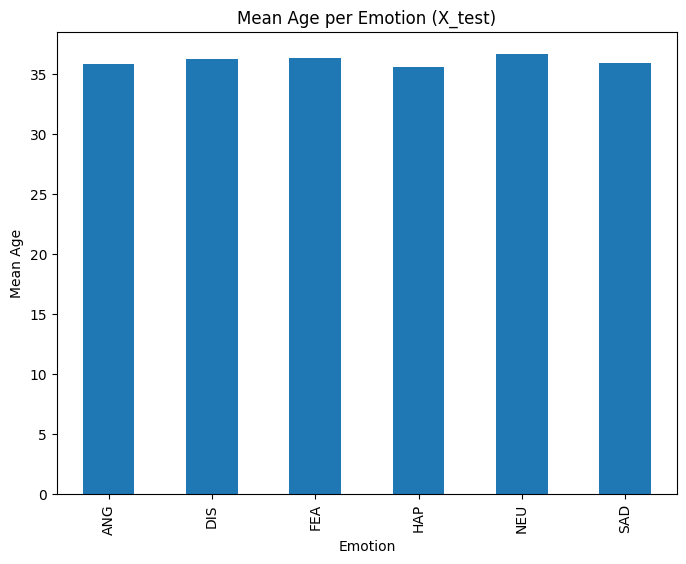

In [11]:
## Age distribution per emotion
plt.figure(figsize=(8,6))
test.groupby("emotion")["Age"].mean().plot(kind="bar")
plt.title("Mean Age per Emotion (X_test)")
plt.ylabel("Mean Age")
plt.xlabel("Emotion")
plt.show()

<Figure size 1000x600 with 0 Axes>

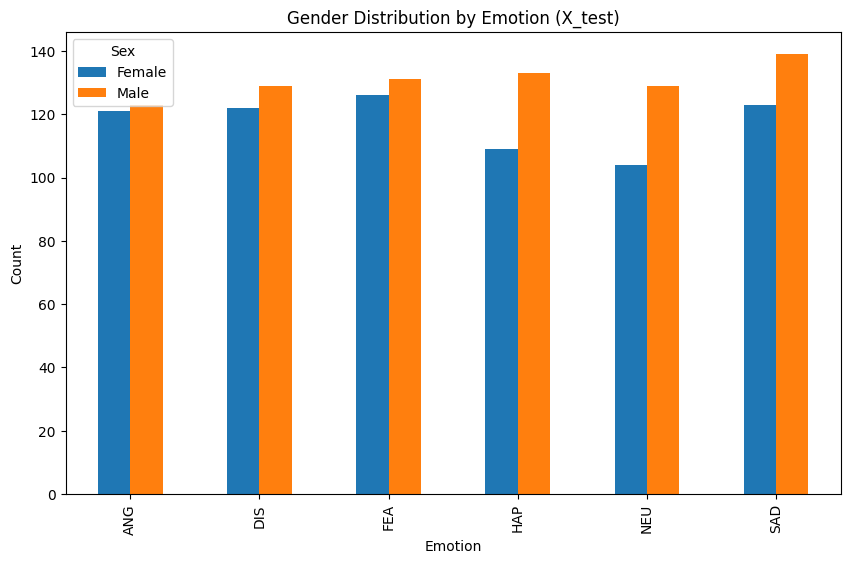

In [12]:
## Sex distribution per emotion
plt.figure(figsize=(10,6))
test.groupby(["emotion", "Sex"]).size().unstack().plot(kind="bar", figsize=(10,6))
plt.title("Gender Distribution by Emotion (X_test)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

<Figure size 1000x600 with 0 Axes>

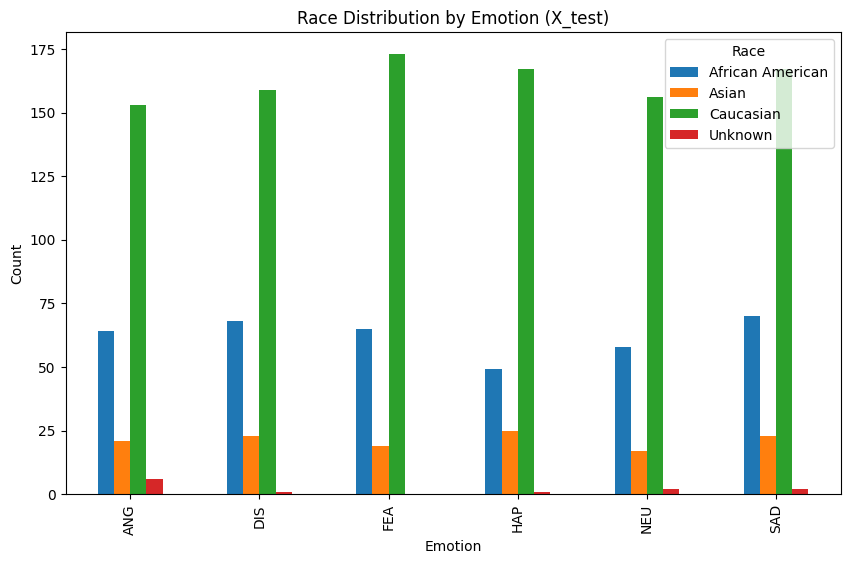

In [13]:
## Race distribution per emotion
plt.figure(figsize=(10,6))
test.groupby(["emotion", "Race"]).size().unstack().plot(kind="bar", figsize=(10,6))
plt.title("Race Distribution by Emotion (X_test)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

## Creating the LSTM model

First, we are going to use the librosa library to extract audio features (Mel-Frequency Cepstrak Coefficient features, or MFCCs) from each audio file in the Crema-D dataset. These features will be added to a list, which will eventually be used to fit the LSTM model. The list is then padded in order to ensure that each series of MFCCs is the same length (preventing audio clip length from disrupting the model's input size).

When loading librosa features, most of the variable are set to default values for human speech. Additionally, a value of 40 MFCC features (for variable n_mfcc) was chosen in order to obtain a higher level of detail for each continuous audio clip.

In [14]:
my_num_mfcc=40  # typical number of mfcc features
my_n_fft=2048  # default audio sampling rate
my_hop_length=512  # default hop length value (256 if you want tailored to speech)
my_sample_rate = 22050  # default sampling rate (in Hz)

def extract_features(filename):
  y, sr = librosa.load(filename, sr=my_sample_rate)

  # turning audio data into Mel-Frequency Cepstral Coefficient features (which represent the power
  # spectra of sound) using the librosa library
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=my_num_mfcc, n_fft=my_n_fft, hop_length=my_hop_length).T
  return mfcc

extracted_features = []

path_prefix = "/content/Bias-in-Emotion-Recognition/data/Crema-D/AudioWAV/"

# creating LSTM features for each audio file in the dataset
for file_row in range(len(crema_d_df)):
  extracted_features.append(extract_features(path_prefix + crema_d_df.iloc[file_row, 0]))

extracted_features_padded = keras.preprocessing.sequence.pad_sequences(extracted_features)

The following code is used to create the LSTM model in keras/tensorflow.

 The created model takes in an input shape that is consistent with the number of MFCCs defined when loading the audio file features using the librosa library (n_mfcc). It contains 2 LSTM layers (each with 250 units), an initial dense layer (with an l2 regularizer and a relu activation) with 100 units, a dropout layer with a value of 0.3, a second dense layer with 80 units (with an l2 regularizer and a relu activation), and an output layer that outputs (a one-hot encoding that describes) one of six possible emotions.  

In [15]:
# creating an LSTM model (test)
input = keras.layers.Input((None, extracted_features_padded.shape[2]))

lstm1 = keras.layers.LSTM(250, return_sequences=True)(input)
lstm2 = keras.layers.LSTM(250, return_sequences=False)(lstm1)

dense1 = keras.layers.Dense(100, kernel_regularizer=regularizers.l2(), activation="relu")(lstm2)
dropout1 = keras.layers.Dropout(0.3)(dense1)

dense2 = keras.layers.Dense(80, kernel_regularizer=regularizers.l2(), activation="relu")(dropout1)

output = keras.layers.Dense(crema_d_df['emotion'].nunique(), activation="softmax")(dense2)

lstm_emotion_identification_model = keras.Model(inputs=input, outputs=output)
lstm_emotion_identification_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 250)      │       291,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 250)            │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        25,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           486 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825,666 (3.15 MB)

 Trainable params: 825,666 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

Compiles the LSTM model using an Adam optimizer with a learning rate of 0.001. Also sets up categorical cross-entropy and categorical accuracy as the loss and metric values respectfully.

In [16]:
lstm_emotion_identification_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss=keras.losses.CategoricalCrossentropy(),
  metrics = [keras.metrics.CategoricalAccuracy()]
)

Preprocesses the X and Y values for the model by generating one-hot encodings for the Y values and setting the X values equal to the padded MFCC features.

In [17]:
# setting up X variables
X = extracted_features_padded

# allowing
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(crema_d_df['emotion'])

# one-hot encoding y_variables
y = tf.keras.utils.to_categorical(y_encoded, crema_d_df['emotion'].nunique())

Fits the model using 40 epochs and a batch size of 15. Shuffles training examples in order to minimize overfitting caused by repeated audio clips taken from the same subject. Also implements early stopping in order to prevent the model from drastically overfitting.

In [18]:
# model fitting
keras.backend.clear_session()
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 4)
fit_model = lstm_emotion_identification_model.fit(X, y, validation_split=0.2, epochs=40, batch_size=15, shuffle=True, callbacks=[early_stopping_callback])

Epoch 1/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - categorical_accuracy: 0.3007 - loss: 2.7285 - val_categorical_accuracy: 0.3821 - val_loss: 1.7081
Epoch 2/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.3822 - loss: 1.6115 - val_categorical_accuracy: 0.3835 - val_loss: 1.5806
Epoch 3/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.4049 - loss: 1.5172 - val_categorical_accuracy: 0.3539 - val_loss: 1.5584
Epoch 4/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.3888 - loss: 1.5010 - val_categorical_accuracy: 0.4083 - val_loss: 1.4804
Epoch 5/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.3967 - loss: 1.4715 - val_categorical_accuracy: 0.4016 - val_loss: 1.4610
Epoch 6/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.4133 - loss: 1.4659 - val_categorical_accuracy: 0.4117 - val_loss: 1.4810
Epoch 7/40
397/397 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - categorical_accuracy: 0.42

Plots the accuracy and loss values of the model (on both training and testing data).

In [19]:
def plot_fit_history(history):
  df = pd.DataFrame(history.history)
  df['epoch'] = np.arange(len(df))

  # Reshape the dataframe to long format
  df_longer = df.melt(id_vars=['epoch'], var_name="measure", value_name="value")

  # Extract measure name and data type (train or validation)
  df_longer['data_type'] = df_longer['measure'].apply(lambda x: 'validation' if x.startswith('val_') else 'training')
  df_longer['measure'] = df_longer['measure'].apply(lambda x: re.sub('val_', '', x))

  return (ggplot(df_longer, mapping=aes(x="epoch", y="value", color="data_type"))+
   geom_line()+
   scale_x_continuous(breaks=np.arange(0, len(df)))+
   facet_wrap('~measure', scales='free_y')+
   labs(x = "Epoch", y="", color="Dataset")+
   theme_bw()+
   theme(panel_grid=element_blank()))

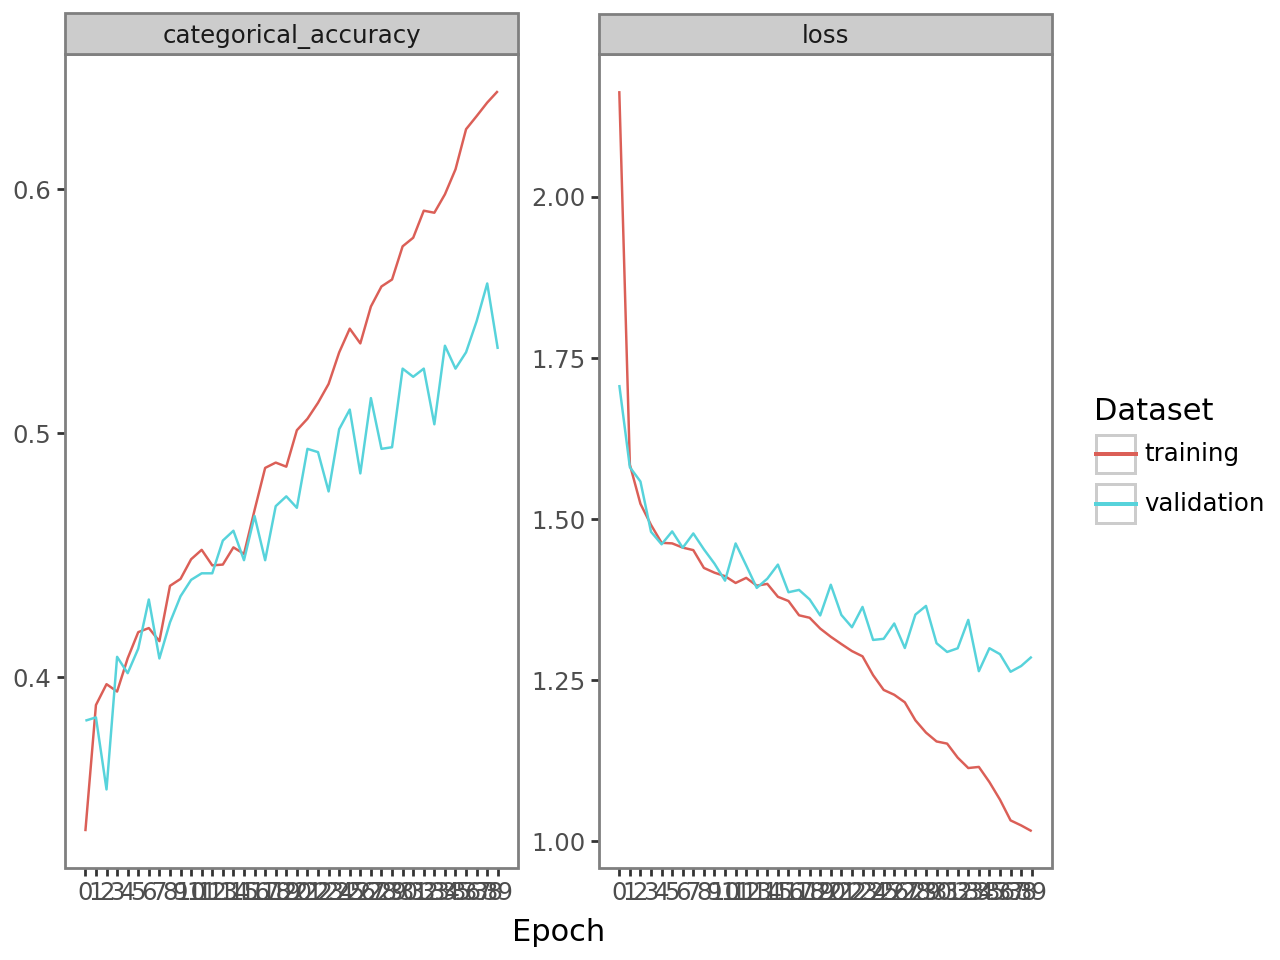

In [20]:
plot_fit_history(fit_model)

As you can see, the model is slowly increasing in accuracy over successive training examples. While the training data and testing data display mostly similar accuracy and loss values throughout training, the early stopping command prevents the model from overfitting once the testing and training data begin to significantly diverge.

**Speech Accent Archive Data**

Loads the audio clips collected from the Speech Accent Archive using the same methods as the Crema-D dataset.

In [21]:
# finds the directory list of all audio files
directory_list = os.listdir("/content/Bias-in-Emotion-Recognition/data/Speech Accent Archive/recordings")

ssa_path = []
ssa_accent = []
ssa_number = []

# for each audio file in the list, adds information from the audio file name into the
# appropriate variable list
for item_name in directory_list:
  ssa_path.append(item_name)
  filtered_name = item_name.removesuffix(".mp3")
  accent_string = ""
  number_string = ''
  for character in filtered_name:
    if character.isdigit():
      number_string = number_string + character
    else:
      accent_string = accent_string + character
  ssa_accent.append(accent_string)
  ssa_number.append(number_string)

# creates a pandas dataframe using the previously created variable lists
ssa_df = pd.DataFrame(zip(ssa_path, ssa_accent, ssa_number))
ssa_df.columns = ["path", "accent", "number"]
ssa_df

,path,accent,number
0,serbian6.mp3,serbian,6
1,japanese7.mp3,japanese,7
2,bulgarian6.mp3,bulgarian,6
3,russian32.mp3,russian,32
4,dutch29.mp3,dutch,29
...,...,...,...
2133,english26.mp3,english,26
2134,arabic10.mp3,arabic,10
2135,farsi17.mp3,farsi,17
2136,turkish10.mp3,turkish,10


Extracts MFCC features from the Speech Accent Archive using the same function as we used on the Crema-D dataset.

In [22]:
ssa_extracted_features = []

path_prefix = "/content/Bias-in-Emotion-Recognition/data/Speech Accent Archive/recordings/"

# creating features for each audio file in the dataset
for file_row in range(len(ssa_df)):
  ssa_extracted_features.append(extract_features(path_prefix + ssa_df.iloc[file_row, 0]))

ssa_extracted_features_padded = keras.preprocessing.sequence.pad_sequences(ssa_extracted_features)

Creates a series of predictions about the emotions displayed in the Speech Accent Archive dataset using the Crema-D-trained LSTM model.

In [23]:
ssa_prediction = lstm_emotion_identification_model.predict(ssa_extracted_features_padded)

67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step


Transforms each prediction output by the LSTM model from a one-hot encoding to one of the six Crema-D emotions. Adds each emotion to the Speech Accent Archive dataframe.

In [24]:
emotion_predictions = []

for file_row in range(len(ssa_prediction)):
  ssa_prediction_argmax = np.argmax(ssa_prediction, axis=-1)
  ssa_prediction_emotion = label_encoder.inverse_transform(ssa_prediction_argmax)
  ssa_df.loc[file_row, 'crema-d predictions'] = ssa_prediction_emotion[file_row]

ssa_df

,path,accent,number,crema-d predictions
0,serbian6.mp3,serbian,6,ANG
1,japanese7.mp3,japanese,7,ANG
2,bulgarian6.mp3,bulgarian,6,ANG
3,russian32.mp3,russian,32,HAP
4,dutch29.mp3,dutch,29,HAP
...,...,...,...,...
2133,english26.mp3,english,26,DIS
2134,arabic10.mp3,arabic,10,HAP
2135,farsi17.mp3,farsi,17,HAP
2136,turkish10.mp3,turkish,10,HAP


In [25]:
# counts the number of unique accents in the speech accent archive
ssa_df["accent"].nunique()

200

Creates three dataframes that filter for the top five most represented, second five most represented, and all other represented accents in the greater, emotion-predicted speech accent archive dataframe. It should be noted that the first two dataframes collectively represent 1203 audio files, or 56.27% of the speech accent archive dataset.

In [26]:
accent_grouping = ssa_df.groupby(["accent"])["crema-d predictions"].count()
most_common_accents = accent_grouping.sort_values(ascending=False)
accents_by_count = most_common_accents.index.tolist()
accents_by_count_top_five = accents_by_count[0:5]
accents_by_count_next_five = accents_by_count[5:10]
accents_by_count_else = accents_by_count[10:]

filtered_emotion_df_top = ssa_df[ssa_df['accent'].isin(accents_by_count_top_five)]
filtered_emotion_df_next = ssa_df[ssa_df['accent'].isin(accents_by_count_next_five)]
filtered_emotion_df_else = ssa_df[ssa_df['accent'].isin(accents_by_count_else)]

In [27]:
filtered_emotion_df_top

,path,accent,number,crema-d predictions
6,french59.mp3,french,59,ANG
8,spanish135.mp3,spanish,135,ANG
9,english218.mp3,english,218,ANG
15,arabic52.mp3,arabic,52,ANG
16,english357.mp3,english,357,ANG
...,...,...,...,...
2130,english477.mp3,english,477,ANG
2132,english337.mp3,english,337,ANG
2133,english26.mp3,english,26,DIS
2134,arabic10.mp3,arabic,10,HAP


In [28]:
filtered_emotion_df_next

,path,accent,number,crema-d predictions
3,russian32.mp3,russian,32,HAP
4,dutch29.mp3,dutch,29,HAP
44,portuguese46.mp3,portuguese,46,NEU
50,russian13.mp3,russian,13,DIS
75,korean8.mp3,korean,8,ANG
...,...,...,...,...
2097,korean6.mp3,korean,6,ANG
2098,turkish7.mp3,turkish,7,ANG
2124,dutch39.mp3,dutch,39,ANG
2131,dutch13.mp3,dutch,13,ANG


Initial plots showing the counts of different emotions displayed in the three previously described dataframes. The graphs will need to be adjusted to account for the relative frequencies of each accent in order to allow for comparisons between emotion frequencies.

<Figure size 640x480 with 0 Axes>

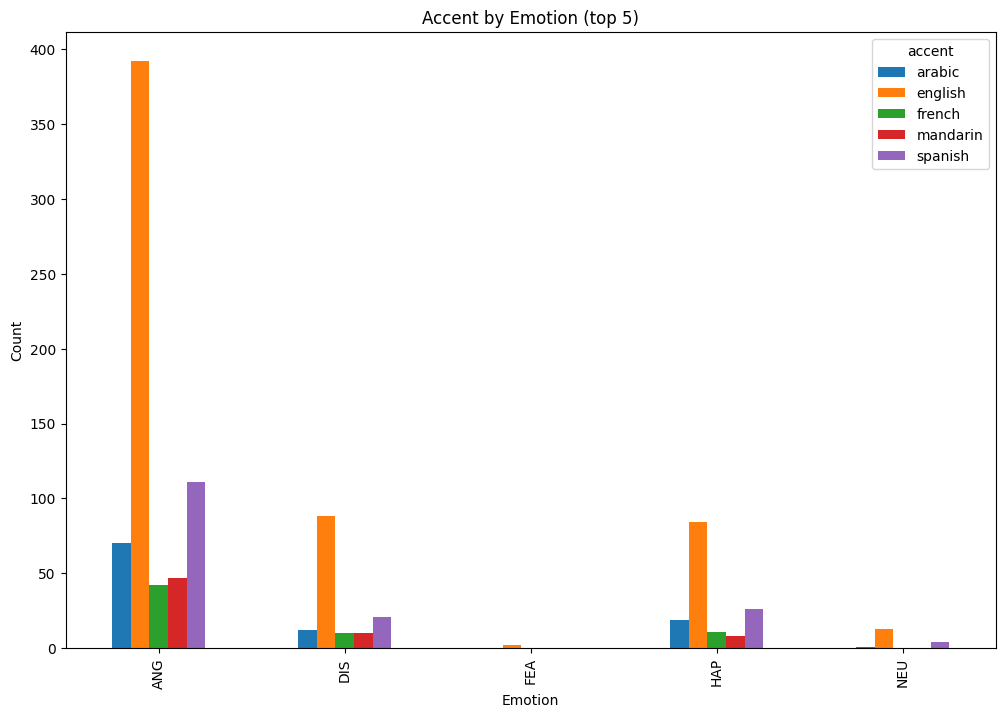

In [29]:
plt.figure()
filtered_emotion_df_top.groupby(["crema-d predictions", "accent"]).size().unstack().plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

<Figure size 640x480 with 0 Axes>

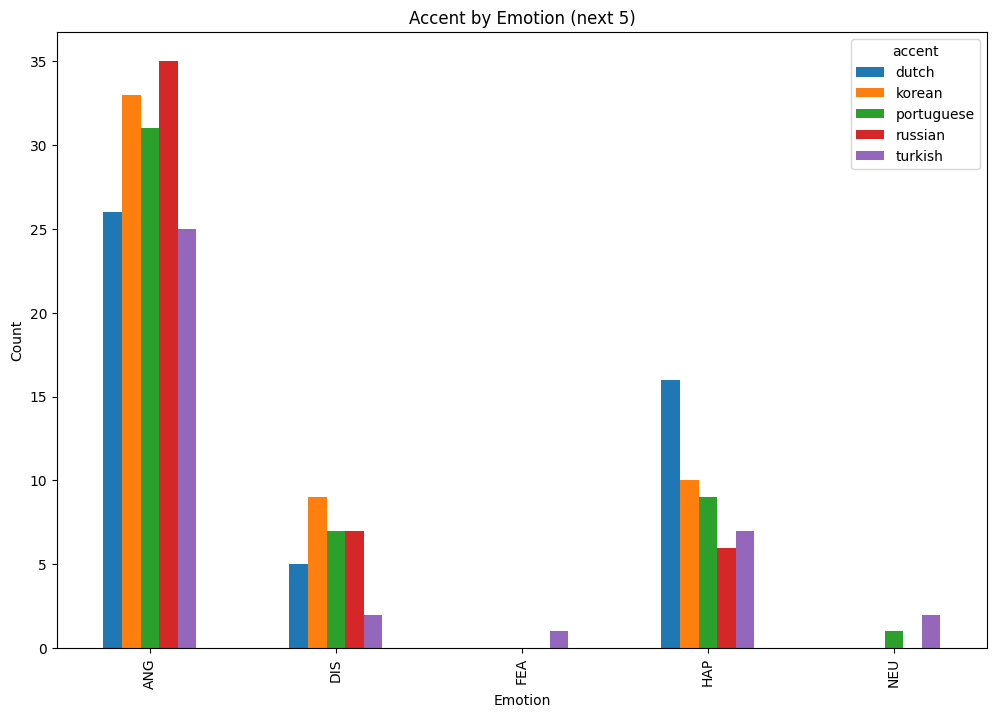

In [30]:
plt.figure()
filtered_emotion_df_next.groupby(["crema-d predictions", "accent"]).size().unstack().plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (next 5)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

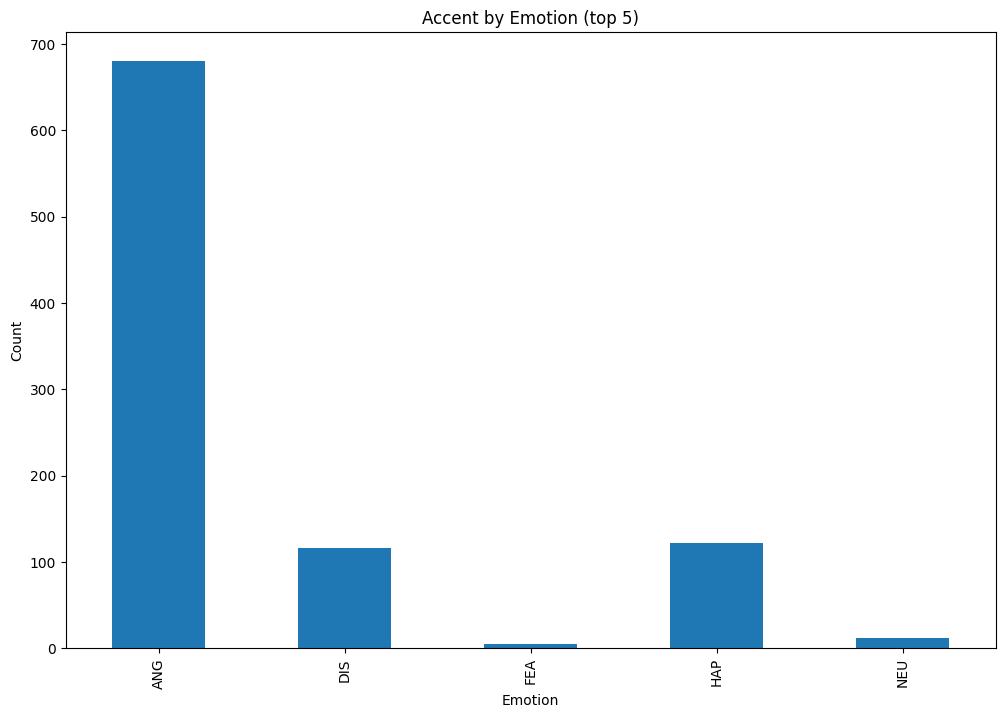

In [31]:
plt.figure()
filtered_emotion_df_else.groupby(["crema-d predictions"]).size().plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [32]:
emotions_list = ["ANG", "DIS", "FEA", "HAP", "NEU", "SAD"]
top_relative_df = filtered_emotion_df_top.groupby(["crema-d predictions", "accent"]).size().unstack().reindex(emotions_list, fill_value=0)
next_relative_df = filtered_emotion_df_next.groupby(["crema-d predictions", "accent"]).size().unstack().reindex(emotions_list, fill_value=0)
else_relative_df = filtered_emotion_df_else.groupby(["crema-d predictions"]).size().reindex(emotions_list, fill_value=0)

In [33]:
top_relative_df

accent,arabic,english,french,mandarin,spanish
crema-d predictions,,,,,
ANG,70.0,392.0,42.0,47.0,111.0
DIS,12.0,88.0,10.0,10.0,21.0
FEA,NaN,2.0,NaN,NaN,NaN
HAP,19.0,84.0,11.0,8.0,26.0
NEU,1.0,13.0,NaN,NaN,4.0
SAD,0.0,0.0,0.0,0.0,0.0


Turns each count dataframe into a percentage dataframe, allowing relative frequencies of results to be compared between accents.

In [34]:
for row in range(len(top_relative_df)):
  for accent in accents_by_count_top_five:
    for emotion in emotions_list:
      column_sum = top_relative_df[accent].sum()
      top_relative_df.loc[emotion, accent] = (top_relative_df.loc[emotion, accent] / column_sum) * 100

for row in range(len(next_relative_df)):
  for n_accent in accents_by_count_next_five:
    for n_emotion in emotions_list:
      column_sum = next_relative_df[n_accent].sum()
      next_relative_df.loc[n_emotion, n_accent] = (next_relative_df.loc[n_emotion, n_accent] / column_sum) * 100

else_percentage_list = []
column_sum_else = else_relative_df.sum()
for item in else_relative_df:
  else_percentage_list.append((item / column_sum_else) * 100)
data = {'Emotion': emotions_list, 'Percentage': else_percentage_list}
else_relative_df = pd.DataFrame(data)

<Figure size 640x480 with 0 Axes>

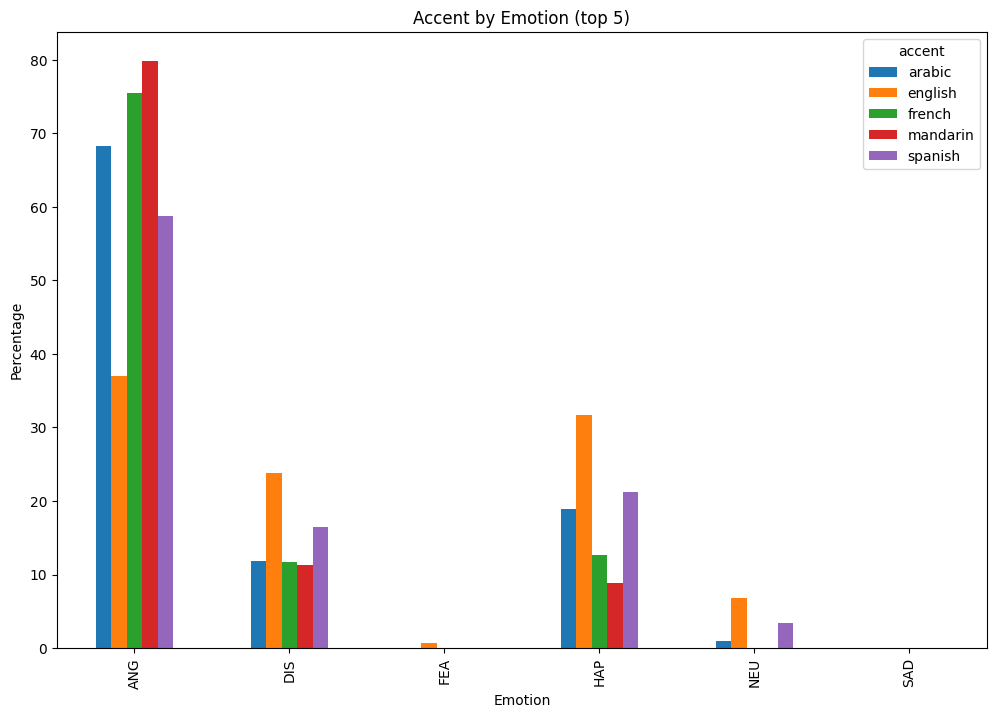

In [35]:
plt.figure()
top_relative_df.plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Percentage")
plt.show()

<Figure size 640x480 with 0 Axes>

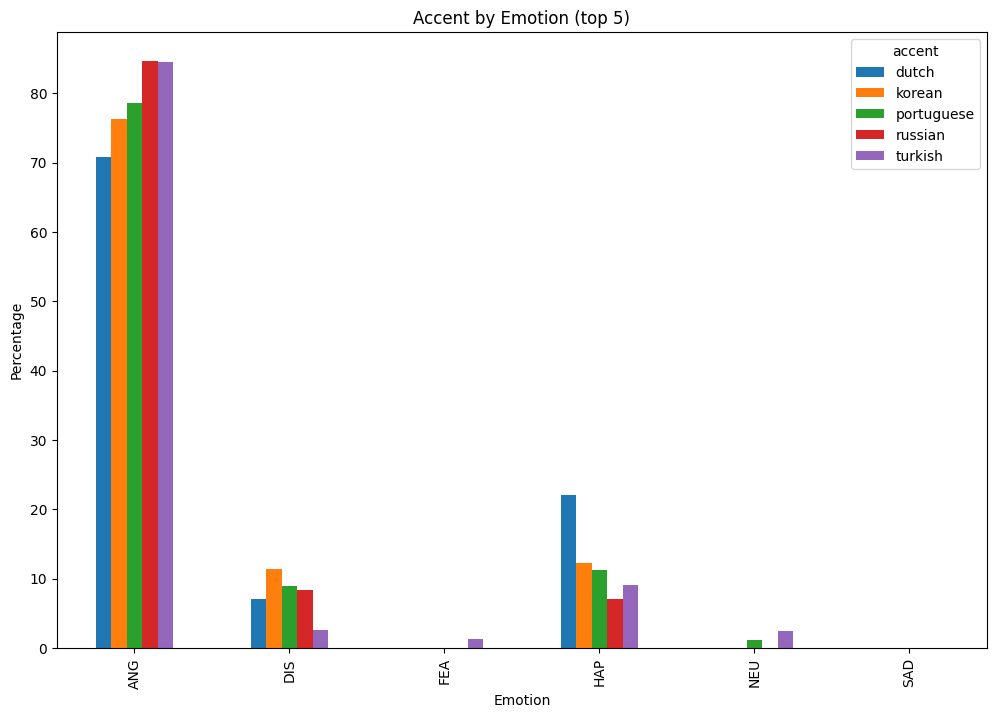

In [36]:
plt.figure()
next_relative_df.plot(kind="bar", figsize=(12,8))
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Percentage")
plt.show()

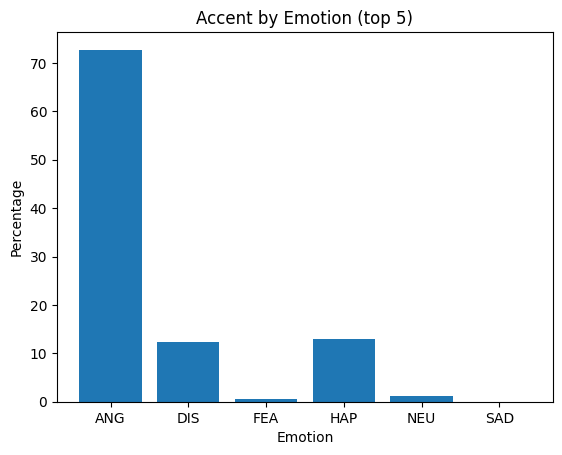

In [37]:
plt.figure()
plt.bar(else_relative_df['Emotion'], else_relative_df['Percentage'])
plt.title("Accent by Emotion (top 5)")
plt.xlabel("Emotion")
plt.ylabel("Percentage")
plt.show()

## Examining Relationships Between Specific Accents

In [38]:
ssa_df.groupby(['accent']).count().sort_values(by=['path'], ascending=False).head(50)

,path,number,crema-d predictions
accent,,,
english,579,579,579
spanish,162,162,162
arabic,102,102,102
mandarin,65,65,65
french,63,63,63
korean,52,52,52
portuguese,48,48,48
russian,48,48,48
dutch,47,47,47


For our statistical testing, we are going to compare a standard english accent with accents from two underrepresented minorities in American society: Mandarin and Spanish.

Mandarin was chosen in order to fill the role of an accent that may be prevelant (even if only a little) in the accents of the Crema-D dataset. Since the Crema-D dataset utilized a small sample of (unspecified) Asian speakers, we chose to use the most well-represented Asian accent in the Speech Accent Archive (Mandarin) to test whether residual accents played in influence in model training.

Similarly, spanish was chosen in order to represent the most common foreign accent in the Speech Accent Archive that was not represented in the Crema-D speaker demographics.

In [39]:
target_data = ssa_df[ssa_df['accent'].isin(['mandarin','english','spanish'])]

In [40]:
from scipy.stats import chi2_contingency

# Create a table with the total counts for each target accent
contingency_table = pd.crosstab(target_data['accent'], target_data['crema-d predictions'])

# Perform the chi-squared test
chi2_statistic, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table)

print(f"Chi-square Statistic: {chi2_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
print("Expected Frequencies:\n", expected_frequencies)

Chi-square Statistic: 3.4045
P-value: 0.9065
Degrees of Freedom: 8
Expected Frequencies:
 [[3.95099256e+02 8.54851117e+01 1.43672457e+00 8.47667494e+01
  1.22121588e+01]
 [4.43548387e+01 9.59677419e+00 1.61290323e-01 9.51612903e+00
  1.37096774e+00]
 [1.10545906e+02 2.39181141e+01 4.01985112e-01 2.37171216e+01
  3.41687345e+00]]


In [41]:
contingency_table

crema-d predictions,ANG,DIS,FEA,HAP,NEU
accent,,,,,
english,392,88,2,84,13
mandarin,47,10,0,8,0
spanish,111,21,0,26,4


As we can see, a Chi-square test reveals a lack of statistically significant differences in the emotion distributions between accents (X^2=7.8240, p>0.05). This indicates that our model is not diverging significantly (between accents) in terms of its predictions.